## 라이브러리는 대충 이런걸 씁니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import konlpy

In [2]:
%matplotlib inline
import tensorflow as tf
tf.__version__

'1.12.0'

# 데이터 읽기 / 확인

In [9]:
df = pd.read_csv('nsmc/ratings_train.txt', sep='\t')

In [97]:
df_test = pd.read_csv('nsmc/ratings_test.txt', sep='\t')

In [10]:
df[:3]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
id          150000 non-null int64
document    149995 non-null object
label       150000 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### 내용 중 비어있는 게 5개 있네요. 일단 삭제합니다.

In [14]:
df = df.dropna().reset_index(drop=True)

In [98]:
df_test = df_test.dropna().reset_index(drop=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149995 entries, 0 to 149994
Data columns (total 3 columns):
id          149995 non-null int64
document    149995 non-null object
label       149995 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### 클래스 임밸런스가 크지 않은 걸 확인합니다.

In [17]:
df.label.value_counts()

0    75170
1    74825
Name: label, dtype: int64

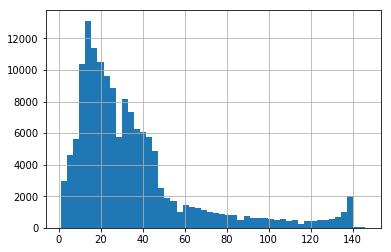

In [19]:
df.document.apply(len).hist(bins=50)

In [21]:
df[df.document.apply(len) < 3].count()

id          1678
document    1678
label       1678
dtype: int64

#### 글자수가 아주 적은 것(2글자 이하)가 좀 있는데요. 일단 POS태깅하고 봅시다.

# POS

In [25]:
from konlpy.tag import Okt

In [28]:
tagger = Okt()

#### POS태깅은 아래처럼 하면 됩니다. 아주 잘 되진 않습니다만 나눠지긴 한다는데에 의의를 둡시다.

In [30]:
posd = tagger.pos(df.loc[0].document)
posd

[('아', 'Exclamation'),
 ('더빙', 'Noun'),
 ('..', 'Punctuation'),
 ('진짜', 'Noun'),
 ('짜증나네요', 'Adjective'),
 ('목소리', 'Noun')]

#### 케라스의 토크나이저는 " "를 기준으로 토크나이징을 합니다. 문자열 구성을 해줘야 하는데요.
#### 1) 이렇게 하거나:

In [32]:
' '.join([i[0] for i in posd])

'아 더빙 .. 진짜 짜증나네요 목소리'

#### 2) 혹은 이렇게 합니다.

In [33]:
' '.join([i[0]+"/"+i[1] for i in posd])

'아/Exclamation 더빙/Noun ../Punctuation 진짜/Noun 짜증나네요/Adjective 목소리/Noun'

#### 3) 혹은 이렇게 특정 품사를 빼줄 수도 있겠죠

In [34]:
' '.join([i[0]+"/"+i[1] for i in posd if i[1] not in ('Punctuation')])

'아/Exclamation 더빙/Noun 진짜/Noun 짜증나네요/Adjective 목소리/Noun'

#### 일단 쉽게쉽게 하기 위해서 1번을 합니다.

In [38]:
def pos_tagged(s, tagger):
    return ' '.join([i[0] for i in tagger.pos(s)])

In [39]:
pos_tagged(df.loc[0].document, tagger)

'아 더빙 .. 진짜 짜증나네요 목소리'

#### train과 test에 모두 pos tag(가 아니라 tokenize)가 된 것을 만들어줍니다.

In [42]:
%%time
df['pos_tagged'] = df.document.apply(lambda x: pos_tagged(x, tagger))

CPU times: user 4min 12s, sys: 224 ms, total: 4min 12s
Wall time: 4min 3s


In [99]:
%%time
df_test['pos_tagged'] = df_test.document.apply(lambda x: pos_tagged(x, tagger))

CPU times: user 1min 23s, sys: 180 ms, total: 1min 23s
Wall time: 1min 22s


#### 웨이팅이 길었으니까 분리된걸 저장 해줍시다. 안 해주면 나중에 4분동안 울 수도 있습니다.

In [44]:
df.to_csv('train_pos.csv')

In [100]:
df_test.to_csv('test_pos.csv')

#### 위에서 봤다시피 토크나이징이 잘 되지 않았습니다. 일단 나중에 처리합시다. (안 할 수도 있음)

In [46]:
df[:5]

,id,document,label,pos_tagged
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 .. 진짜 짜증나네요 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍지 않구나
2,10265843,너무재밓었다그래서보는것을추천한다,0,너 무재 밓었 다그 래서 보는것을 추천 한 다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기 구먼 .. 솔직히 재미 는 없다 .. 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 ! 스파이더맨 에서 늙어 보이기만...


#### 토큰길이가 너무 짧은것들은 학습에 방해가 될 수도 있는데요. 토큰길이가 어떤지 좀 보죠.

In [47]:
df['token_len'] = df['pos_tagged'].apply(lambda x: len(x.split(' ')))

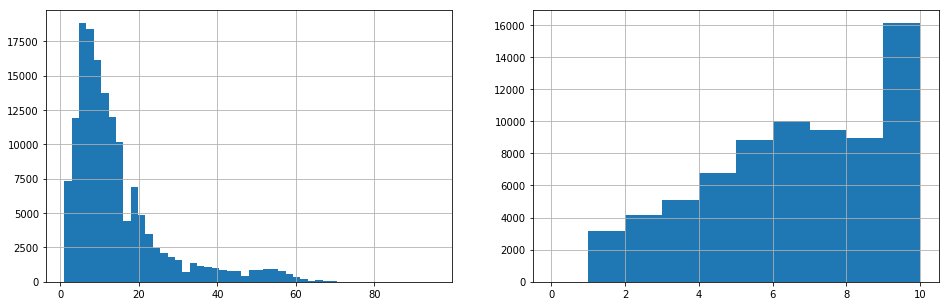

In [58]:
fig, axes = plt.subplots(1,2, figsize=(16,5))
df['token_len'].hist(ax=axes[0], bins=50,)
df['token_len'].hist(ax=axes[1], bins=10, range=(0,10))

#### 아주 짧은게 그렇게 많지는 않은데요. 어떻게 생겼는지 좀 볼까요.

In [61]:
df.query("token_len<2")[:10]

,id,document,label,pos_tagged,token_len
28,6091784,재밋는뎅,1,재밋는뎅,1
54,7207064,재미있어요,1,재미있어요,1
56,1651126,최고,0,최고,1
72,5679106,졸작,0,졸작,1
106,7747745,킬링타임,0,킬링타임,1
113,7115568,대박,1,대박,1
140,3685947,좋구나,1,좋구나,1
151,7348295,아,0,아,1
185,1870395,버려,0,버려,1
278,7124022,망함,0,망함,1


#### 길이때문에 데이터를 버리는 일은 안 해도 될 것 같습니다.

In [66]:
df['token_len'].quantile([0.9,0.95,0.99,0.999])

0.900    30.0
0.950    43.0
0.990    58.0
0.999    66.0
Name: token_len, dtype: float64

#### 99% 이상의 리뷰들의 토큰길이가 60 이하입니다.

In [200]:
MAX_LENGTH = 60

In [92]:
from collections import Counter
c = Counter()
def _tmp(x):
    for w in x.split(' '): 
        c[w]+=1
    return None
df['pos_tagged'].apply(_tmp)
for i in [10, 20, 50]:
    print("tokens occured over %s: %s" % (i, len([w for w in c if c[w]>i])))

tokens occured over 10: 12536
tokens occured over 20: 7679
tokens occured over 50: 3804


In [201]:
MAX_FEATURES = 5000

# 임베딩

이 코드를 보여주기 위해 이 문서를 작성했습니다.  
한국어 데이터를 분석하는 노트북은 몇 개 있었는데, 워드 임베딩을 사용하는 문서가 없네요.  
없어서 제가 만들어보았습니다 (그런데 정확도가 더 낮음...)

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

#### 여기서 토크나이저를 만들어주고요. num_words는 상위 몇 개의 단어를 사용할거냐는 얘깁니다.
위에서 보니까 20번~50번 이상 등장하는 단어가 한 5000개쯤 되네요. 그렇게 합시다.

In [202]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)

#### 토크나이저를 피팅해줍니다. 피팅을 해줘야 word->integer로 transform이 되겠죠.

In [203]:
tokenizer.fit_on_texts(df['pos_tagged'])

#### 피팅 한 토크나이저를 사용해서 document를 sequence of integer로 바꿔줍니다.

In [219]:
X_train = tokenizer.texts_to_sequences(df['pos_tagged'])
X_test = tokenizer.texts_to_sequences(df_test['pos_tagged'])

#### 아래 코드를 참조하시면 어떻게 바뀌었는지 아시겠죠.
'밓었'이 207번째 단어라니, 토크나이징이 하하하... 이런 건 전처리에서 처리해줄 수도 있고, 토크나이저를 바꿀 수도 있습니다. 저는 '밓'같은 건 전처리에서 처리하는 걸 선호합니다만, 일단 계속 진행합시다.  
(만약 토크나이저를 바꾸고싶다면, konlpy말고 soynlp를 쓰는걸 고려해보세요.)

In [223]:
df['pos_tagged'][:3].apply(lambda x: x.split(' ')).values

array([list(['아', '더빙', '..', '진짜', '짜증나네요', '목소리']),
       list(['흠', '...', '포스터', '보고', '초딩', '영화', '줄', '....', '오버', '연기', '조차', '가볍지', '않구나']),
       list(['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'])],
      dtype=object)

In [220]:
X_train[:3]

[[51, 451, 18, 659],
 [910, 452, 47, 608, 2, 203, 1582, 23, 986],
 [376, 2900, 207, 13, 14]]

#### pad_sequence
MAX_LENGTH가 60이니까, 우리는 뉴럴넷에 길이 60의 시퀀스를 집어넣을겁니다. 그런데 길이 4짜리 시퀀스를 넣으면 안 되겠죠. 그러니까 길이를 60으로 맞춰줘야 합니다.  
pad_sequence가 그 기능을 합니다.

In [224]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LENGTH)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (149995, 60)
X_test shape: (49997, 60)


In [226]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   51,  451,   18,  659],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  910,  452,   47,  608,
           2,  203, 1582,   23,  986]], dtype=int32)

#### 이제 데이터가 모두 준비되었습니다. 뉴럴넷에 집어넣으면 끝!

In [205]:
y_train = df['label']
y_test = df_test['label']

# Keras

In [194]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Flatten
from tensorflow.keras import optimizers

## FFN

In [206]:
print('Build model...')
model = Sequential()
model.add(Embedding(MAX_FEATURES, 100, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 60, 100)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 6001      
Total params: 506,001
Trainable params: 506,001
Non-trainable params: 0
_________________________________________________________________
None


In [207]:
print('Train...')
model.fit(X_train, y_train, batch_size=1024, epochs=10,
          validation_data=(X_test, y_test), verbose=2)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=1024, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 149995 samples, validate on 49997 samples
Epoch 1/10
 - 6s - loss: 0.5375 - acc: 0.7492 - val_loss: 0.4002 - val_acc: 0.8217
Epoch 2/10
 - 1s - loss: 0.3619 - acc: 0.8403 - val_loss: 0.3685 - val_acc: 0.8331
Epoch 3/10
 - 1s - loss: 0.3377 - acc: 0.8516 - val_loss: 0.3651 - val_acc: 0.8356
Epoch 4/10
 - 1s - loss: 0.3245 - acc: 0.8576 - val_loss: 0.3676 - val_acc: 0.8339
Epoch 5/10
 - 1s - loss: 0.3114 - acc: 0.8646 - val_loss: 0.3694 - val_acc: 0.8348
Epoch 6/10
 - 1s - loss: 0.2975 - acc: 0.8719 - val_loss: 0.3734 - val_acc: 0.8336
Epoch 7/10
 - 1s - loss: 0.2832 - acc: 0.8789 - val_loss: 0.3807 - val_acc: 0.8289
Epoch 8/10
 - 1s - loss: 0.2686 - acc: 0.8862 - val_loss: 0.3887 - val_acc: 0.8284
Epoch 9/10
 - 1s - loss: 0.2544 - acc: 0.8940 - val_loss: 0.4003 - val_acc: 0.8247
Epoch 10/10
 - 1s - loss: 0.2410 - acc: 0.9008 - val_loss: 0.4118 - val_acc: 0.8224
Test score: 0.4117943567903213
Test accuracy: 0.8224293453947512


#### 안타깝게도 정확도가 85%가 안 나옵니다. 이 문서의 목적은 더 잘 예측하자는 게 아니니까 일단 넘어갑시다.

## LSTM

In [208]:
print('Build model...')
model = Sequential()
model.add(Embedding(MAX_FEATURES, 100, input_length=MAX_LENGTH))
model.add(LSTM(60))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 60, 100)           500000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 60)                38640     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 61        
Total params: 538,701
Trainable params: 538,701
Non-trainable params: 0
_________________________________________________________________
None


In [209]:
print('Train...')
model.fit(X_train, y_train, batch_size=1024, epochs=10,
          validation_data=(X_test, y_test), verbose=0)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=1024, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Test score: 0.5466980384948681
Test accuracy: 0.8296297777294434


## LSTM*2

In [217]:
print('Build model...')
model = Sequential()
model.add(Embedding(MAX_FEATURES, 100, input_length=MAX_LENGTH))
model.add(LSTM(60, return_sequences=True))
model.add(LSTM(60))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 60, 100)           500000    
_________________________________________________________________
lstm_32 (LSTM)               (None, 60, 60)            38640     
_________________________________________________________________
lstm_33 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 61        
Total params: 567,741
Trainable params: 567,741
Non-trainable params: 0
_________________________________________________________________
None


In [218]:
print('Train...')
model.fit(X_train, y_train, batch_size=512, epochs=10,
          validation_data=(X_test, y_test), verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=512, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 149995 samples, validate on 49997 samples
Epoch 1/10
149995/149995 [==============================] - 51s 339us/step - loss: 0.3971 - acc: 0.8166 - val_loss: 0.3528 - val_acc: 0.8407
Epoch 2/10
149995/149995 [==============================] - 43s 289us/step - loss: 0.3239 - acc: 0.8552 - val_loss: 0.3423 - val_acc: 0.8443
Epoch 3/10
149995/149995 [==============================] - 43s 290us/step - loss: 0.2965 - acc: 0.8685 - val_loss: 0.3468 - val_acc: 0.8418
Epoch 4/10
149995/149995 [==============================] - 44s 295us/step - loss: 0.2728 - acc: 0.8807 - val_loss: 0.3480 - val_acc: 0.8442
Epoch 5/10
149995/149995 [==============================] - 43s 289us/step - loss: 0.2486 - acc: 0.8927 - val_loss: 0.3527 - val_acc: 0.8431
Epoch 6/10
149995/149995 [==============================] - 43s 290us/step - loss: 0.2243 - acc: 0.9049 - val_loss: 0.3866 - val_acc: 0.8370
Epoch 7/10
149995/149995 [==============================] - 43s 290us/step - loss: 0.2040 - ac

In [210]:
def evaluate(df):
    x = tokenizer.texts_to_sequences(df['pos_tagged'])
    x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=MAX_LENGTH)
    score, acc = model.evaluate(x, df['label'],
                            batch_size=1024, verbose=2)
    print('Test score:', score)
    print('Test accuracy:', acc)

In [211]:
df_test['token_len'] = df_test['pos_tagged'].apply(lambda x: len(x.split(' ')))

In [212]:
evaluate(df_test.query('token_len>10'))

Test score: 0.572366543493087
Test accuracy: 0.8416286091131271


# 일단 끝

## 정확도를 높이기 위해
#### 모델을 수정하면 편하겠죠.
dropout을 하면 정확도가 높으질 수도 있습니다.  
CNN을 쓰면 개선이 편하겠죠. 속도가 훨씬 빠르니까요.  
#### 하지만 근본적인 해결을 위해선 역시 데이터를 더 봐야 합니다.
punctuation을 제외했는데, 사실은 저게 성능에 큰 영향을 줄 수도 있습니다.  
그리고 아마 토크나이징에 큰 문제가 있을겁니다. 더 잘 해봅시다.  
2글자 이하인 리뷰들은 아예 제외해버리는것도 좋습니다.  